Felipe Marinho Tavares 
RA 265680

# Brain MRI classification using Deep Learning

Nesta atividade, o objetivo, mais uma vez, é classificar imagens de ressonância magnética do cérebro em imagens com tumor (*tumor*) e imagens sem tumor (*health*). Para simplificar a tarefa, as imagens já foram processadas e, ao invés de serem fornecidas como imagens volumétricas (3D) em formato DICOM, elas estão sendo fornecidas como fatias (imagens 2D) e no formato jpg.

Em contraste com a atividade da semana passada, usaremos uma rede neural convolucional (CNN) para a classificação. Ou seja, diferentemente do *pipeline* de classificação tradicional, os atributos serão extraídos pela própria CNN e não teremos que nos preocupar com isso.

Este notebook mostra como se faz para carregar as imagens, descrever a CNN a ser usada, treinar e predizer. O treinamento mostrado não trata os dados antes de inseri-los na rede nem utiliza as técnicas mais avançadas de Deep Learning, como *data augmentation* e *transfer learning*. A ideia é que você explore estes passos adicionais, tentando melhorar a acurácia de classificação.


In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

# connect drive
from google.colab import drive
drive.mount('/content/gdrive')

!ls 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
test  train  val


## **Parte 1 - Carregando os dados (imagens e rótulos) usando o DataLoader**

Normalmente treinamento de CNNs pressupõe o uso de conjuntos de dados muito grandes. O carregamento destes conjuntos de dados em um NB pode dar bastante trabalho e causar problemas, como falta de memória, dentre outros. Para isso, costumamos usar um *dataloader*, especificamente desenvolvido para isso. Para mais informações sobre *dataloader* consulte o [link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

**Pre-processamento dos dados e Data Augmentation**

As tranformações que queremos fazer nos dados precisam ser definidas antes de chamar o DataLoader. Assim, quando ele carrega os dados, já aplica as transformações desejadas. Você verá que a única transformação que está sendo feita é um redimensionamento das imagens (transform.Resize). Isso é feito pois a CNN só consegue lidar com imagens de treinamento do mesmo tamanho. As outras linhas comentadas da parte do código que faz as transformações dos dados podem ser usadas e modificadas, como forma de fazer um aumento de dados e assim, ajudar no treino. Consulte a documentação sobre *transforms* do Pytorch: https://pytorch.org/vision/stable/transforms.html.

**ATENÇÃO**
Se você escolheu aplicar alguma transformação (por ex: *resize*, *normalize*) com o intuito de pre-processamento, você deve aplicá-la a todos os conjuntos (**train, val, test**). Porém, se você escolheu uma transformação (por ex: *RandomHorizontalFlip*) como forma de aumento de dados, ela deve ser aplicada somente ao conjunto de treinamento (**train**) e, de preferência, de forma aleatória.

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
    ]),
}

data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## **Visualizando algumas imagens (one batch)**

Muitas vezes treinamos uma rede neural em *batches*, quer dizer, separamos o conjunto de treino em sub-conjuntos menores. Se temos um conjunto de treino de M amostras, podemos ter M *batches* de tamanho 1 até 1 *batch* de tamanho M. Nesse nosso exemplo, escolhemos um tamanho de batch = 24. Para mais detalhes sobre como escolher o tamanho de um *batch*, veja este [link](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) . 

Batch of training data


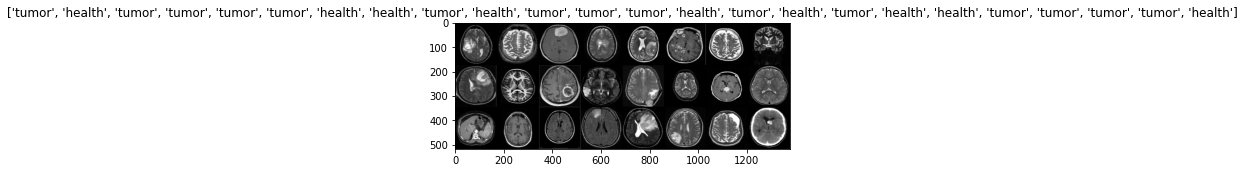

min =  0.0
median =  0.19607843
mean =  0.22897963
max =  1.0
Batch of validation data


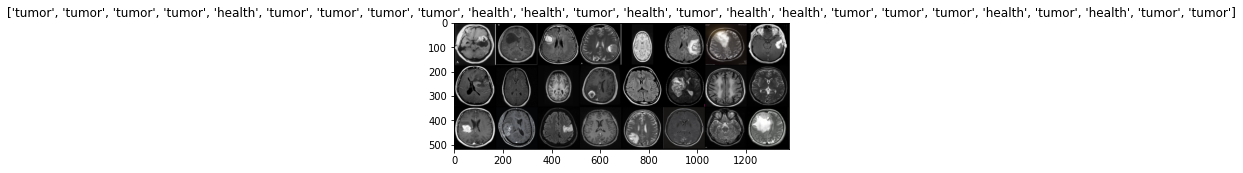

min =  0.0
median =  0.22352941
mean =  0.23987558
max =  1.0
Batch of test data


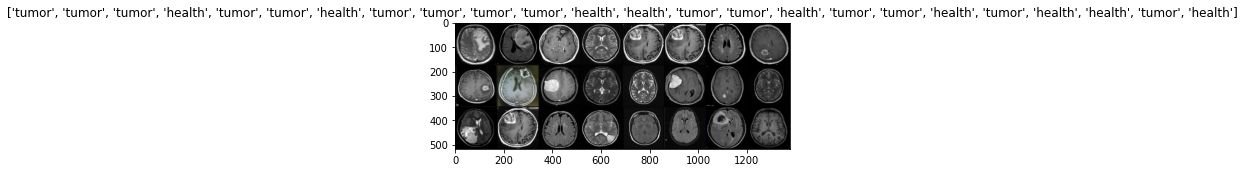

min =  0.0
median =  0.23921569
mean =  0.25266334
max =  1.0


In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

#**Parte 2 - Definindo o modelo a ser treinado e os parâmetros de treinamento**

Antes de começar a treinar uma CNN, é preciso definir o processo de treinamento e os parâmetros iniciais do modelo a ser treinado (arquitetura, learning rate, critério de otimização, etc). Não se preocupe com a primeira parte do código (2.1), de definição do processo de treinamento. Se quiser tentar melhorar a acurácia mexendo no modelo, altere os parâmetros do modelo (2.2). Você verá que neste trecho há várias linhas comentadas, dando ideias de possíveis alterações. Para a documentação sobre parâmetros de treinamento: [link](https://pytorch.org/docs/stable/optim.html)

###**2.1 - Definindo o processo de treinamento**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


###**2.2 - Definindo os parâmetros do modelo e do treinamento**

In [ ]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
# print(model) # mostrando a arquitetura da CNN escolhida

summary(model, (3, 170, 170)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

#**Parte 3 - Treinando a CNN**

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

#model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=200)
model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=1000)

Streaming output truncated to the last 5000 lines.
train Loss: 0.9439 Acc: 0.3864
val Loss: 0.8524 Acc: 0.4314

Epoch 1/999
----------
train Loss: 0.7722 Acc: 0.4375
val Loss: 0.7927 Acc: 0.3333

Epoch 2/999
----------
train Loss: 0.6548 Acc: 0.6136
val Loss: 0.7366 Acc: 0.5294

Epoch 3/999
----------
train Loss: 0.6146 Acc: 0.6705
val Loss: 0.7150 Acc: 0.5686

Epoch 4/999
----------
train Loss: 0.5701 Acc: 0.6932
val Loss: 0.6864 Acc: 0.5686

Epoch 5/999
----------
train Loss: 0.5466 Acc: 0.7045
val Loss: 0.6669 Acc: 0.6275

Epoch 6/999
----------
train Loss: 0.5080 Acc: 0.7614
val Loss: 0.6507 Acc: 0.6275

Epoch 7/999
----------
train Loss: 0.4914 Acc: 0.8125
val Loss: 0.6289 Acc: 0.6667

Epoch 8/999
----------
train Loss: 0.4678 Acc: 0.8352
val Loss: 0.6150 Acc: 0.6275

Epoch 9/999
----------
train Loss: 0.4504 Acc: 0.8409
val Loss: 0.5934 Acc: 0.6275

Epoch 10/999
----------
train Loss: 0.4349 Acc: 0.8807
val Loss: 0.5714 Acc: 0.6275

Epoch 11/999
----------
train Loss: 0.4130 Acc:

###**Mostrando as curvas de treinamento**

Através das curvas de acurácia e de erro nos conjuntos de treinamento e validação, é possível responder algumas perguntas com relação ao treinamento: houve *overfitting*? o número de épocas não foi suficiente? Quando treinamos uma CNN, é importante observarmos essas curvas e não somente a acurácia final. Há vários textos sobre como avaliar o treinamento de um modelo a partir das curvas, veja um exemplo [aqui](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

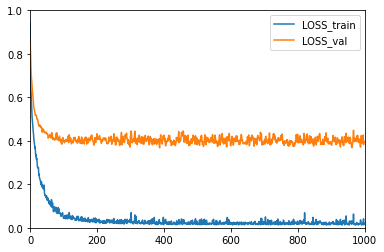

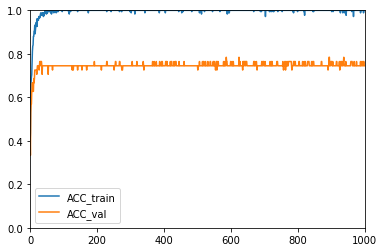

max ACC =  tensor(0.7843, device='cuda:0', dtype=torch.float64)


In [ ]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

**Discussão**

A principio não houve overfitting, o resultado na validação não piorou enquanto o do treino continuou a melhorar.
Pelo uso de transfer learning e aumento do número de epochs, já que com 200 epochs as curvas de loss ainda mostram espaço para melhoria sem overfitting, o modelo conseguiu ter resultados finais melhores na validação.

###**Visualizando as predições no grupo de teste**

In [ ]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(len(labels))

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)

In [ ]:
test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)




 Conjunto de Teste 

labels =  ['health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health']
matriz de confusão = 
 [[ 9  1]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.9
acc =  0.9615384615384616


**Discussão**

Comparado com o uso de SVM para classificação de imagens, o uso de CNN e, notoriamente, de transfer learning (ao aproveitar redes pretreinadas em um número grande de imagens) destacou um aumento considerável da métrica especificidade do modelo estatístico .

Em relação aos parâmetros da rede para treinamento, a influência de usar momento na função de otimização do gradiente descendente permitiu atingir melhores resultados de loss e acurácia muito antes.

Em relação ao uso ou não do transfer learning ficou claro que o "fine-tuning" do modelo exige o treinamento durante mais épocas já que quando se rodou com apenas 200 épocas as curvas não mostraram comportamento de overfitting e um considerável espaço para melhoria que foi explorado ao permitir o treinamento até 1000 épocas. Ao analisar as curvas de loss e acurácia no conjunto de treino e validação, a rede parece ter atingindo o platô por volta da época 400.
